# Figure 1. *In vitro* reconstitution of DROSHA processing
---

In [8]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-20.


In [9]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [10]:
from __future__ import division
import sys; sys.path.append(utilpath)
from basic import gen_result_dir
from util import *
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/210120/


In [11]:
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec
from collections import defaultdict, Counter
from scipy.stats import pearsonr, spearmanr, sem
from os import listdir
%matplotlib inline

In [12]:
PILOT = [ 'pilot-1', 'pilot-2' ]
SET1 = [ 'set1-1', 'set1-2' ]
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [13]:
s1 = pd.read_csv('supplementary/TableS1__Previously_identified_DROSHA-dependence.csv', 
                 header=1, index_col=0)
s2 = pd.read_csv('supplementary/TableS2__Oligonucleotides_used_in_this_study.csv', 
                 header=1, index_col=0).fillna('')

In [17]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [19]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
print len(drodep), len(droind)

311 257


## S1C. Flanking segments in miRBase hairpin

In [20]:
def parse_line(row):
    for s in row['attr'].split(';'):
        tag, value = s.split('=')
        row[tag] = value
    return row

In [21]:
# miBRase v21 gff file
gff = 'supplementary/human_mirbase-v21.gff3'
anntbl = pd.read_table(gff, header=12, sep='\t', usecols=[0,2,3,4,6,8], 
                       names=['chr','kind','start','end','strand','attr'])
anntbl = anntbl.apply(parse_line, axis=1).drop(['attr'], axis=1)
anntbl.head(3)

,Alias,Derives_from,ID,Name,chr,end,kind,start,strand
0,MI0022705,NaN,MI0022705,hsa-mir-6859-1,chr1,17436,miRNA_primary_transcript,17369,-
1,MIMAT0027618,MI0022705,MIMAT0027618,hsa-miR-6859-5p,chr1,17431,miRNA,17409,-
2,MIMAT0027619,MI0022705,MIMAT0027619,hsa-miR-6859-3p,chr1,17391,miRNA,17369,-


In [22]:
annpri = anntbl[anntbl['kind']=='miRNA_primary_transcript'].set_index('Name')
annmat = anntbl[anntbl['kind']=='miRNA'].set_index('ID')
allpris = sorted(annpri.index)
print len(allpris)

1881


In [23]:
# pri-mature matching
primat = {}
for pri, row in annpri.iterrows():
    matureDerives = anntbl[anntbl['Derives_from']==row['ID']]
    primat[pri] = matureDerives['Name'].tolist()
print primat['hsa-let-7a-1']

['hsa-let-7a-5p', 'hsa-let-7a-3p']


In [24]:
hpnseqf = 'supplementary/hairpin_mirbase-v21.fa'
matseqf = 'supplementary/mature_mirbase-v21.fa'
hpnseqs = { s.id:str(s.seq) for s in SeqIO.parse(hpnseqf, 'fasta') }
matseqs = { s.id:str(s.seq) for s in SeqIO.parse(matseqf, 'fasta') }
print len(hpnseqs)

28645


In [25]:
def determine_arm(pri, mat):
    preseq = s2.loc[pri,'Pre-miRNA']
    matseq = matseqs[mat]
    if preseq.startswith(matseq):
        return '5p'
    else:
        return '3p'

In [26]:
# miRBase hairpin
flank5, flank3 = {}, {}
for pri in s1.index:
    hpn = hpnseqs[pri]
    for mat in primat[pri]:
        arm = determine_arm(pri,mat)
        if arm=='5p':
            flank5[pri] = hpn.find(matseqs[mat])
        else:
            flank3[pri] = hpn[::-1].find(matseqs[mat][::-1])
print len(flank5), len(flank3)

1408 1405


In [27]:
xs = np.arange(31)
bins = zip(range(31),range(30)+[100])
ys1 = [ len([p for p in flank5 if lb<=flank5[p]<=ub]) for lb,ub in bins ]
ys2 = [ len([p for p in flank3 if lb<=flank3[p]<=ub]) for lb,ub in bins ]

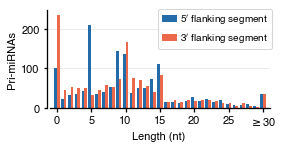

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4,1.8))
ax.bar(xs-.2,ys1,fc='#236ba9',width=.4,zorder=2,label='5$^\prime$ flanking segment')
ax.bar(xs+.2,ys2,fc='#ec684a',width=.4,zorder=2,label='3$^\prime$ flanking segment')

ax.set_xlabel('Length (nt)')
ax.set_ylabel('Pri-miRNAs')
ax.set_xticks(range(0,31,5))
ax.set_xticklabels(range(0,30,5)+['$\geq$30'])
ax.yaxis.grid(ls='-',lw=.5)
ax.set_xlim(-1.5,31)
ax.spines['bottom'].set_bounds(-1,31)
ax.legend(handlelength=1.5, handletextpad=.3, loc=(.5,.6))
#fig.savefig(resultpath + '210118_s1__flank_mirbase.pdf')

## S1D. Conservation of flanking segment

In [29]:
def get_phylop_scores(chrom, start, end):
    savepath = 'supplementary/phyloP100way'
    phystarts = [ int(f.split('.')[0]) for f in listdir('%s/%s'%(savepath,chrom)) 
                  if f.endswith('.gz') ]
    init = sorted([ s for s in phystarts if s<=start ])[-1]
    nextst = sorted([ s for s in phystarts if s>start])[0]
    rels, rele = start-init, end-init
    phys = open('%s/%s/%s.phylop.gz'%(savepath,chrom,init),'rt').read().strip().split('\n')
    if len(phys) <= rels:
        if nextst > end:
            return ['-']*(end-start+1)
        else:
            return ['-']*(nextst-start) + get_phylop_scores(chrom, nextst, end)
    elif len(phys) > rele:
        return map(float, phys[rels:rele+1])
    else: # rels < len(phys) <= rele
        return map(float, phys[rels:]) + get_phylop_scores(chrom, init+len(phys), end)

In [30]:
conserv5, conserv3 = {}, {}
for pri in drodep:
    chrom, pstart, pend, strand = get_pre_annot(pri)
    if strand=='+':
        conserv5[pri] = get_phylop_scores(chrom, pstart-50, pstart-1)
        conserv3[pri] = get_phylop_scores(chrom, pend+1, pend+50)[::-1]
    else:
        conserv3[pri] = get_phylop_scores(chrom, pstart-50, pstart-1)
        conserv5[pri] = get_phylop_scores(chrom, pend+1, pend+50)[::-1]

In [31]:
xs = np.arange(-50,0)
ps5 = zip(*[ conserv5[pri] for pri in drodep ])
ys5 = [ np.average([p for p in ps if p!='-']) for ps in ps5 ]
es5 = [ sem([p for p in ps if p!='-']) for ps in ps5 ]
ps3 = zip(*[ conserv3[pri] for pri in drodep ])
ys3 = [ np.average([p for p in ps if p!='-']) for ps in ps3 ]
es3 = [ sem([p for p in ps if p!='-']) for ps in ps3 ]
c5, c3, shade = '#4292c6', '#807dba', '#dddddd'
c3, c5, shade = '#c61d21', '#004597', '#dddddd'

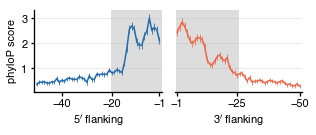

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.8,1.5), sharey=True)
fig.subplots_adjust(wspace=.1)

ax1.errorbar(xs, ys5, color='#236ba9', yerr=es5, elinewidth=.8, zorder=2)
ax2.errorbar(xs, ys3, color='#ec684a', yerr=es3, elinewidth=.8, zorder=2)
ax1.axvspan(-20.5, -.5, color=shade)
ax2.axvspan(-25.5, -.5, color=shade)

ax1.set_xticks([-1,-20,-40])
ax2.set_xticks([-1,-25,-50])

for ax in [ax1,ax2]:
    ax.yaxis.grid(ls='-',lw=.5)
    ax.set_xlim(-51,0)
ax1.set_xlabel('5$^\prime$ flanking')
ax2.set_xlabel('3$^\prime$ flanking')
ax1.set_ylabel('phyloP score')
ax2.invert_xaxis()
ax2.spines['left'].set_visible(False)
ax2.tick_params(left='off')
#fig.savefig(resultpath + '210118_s1__flanking_conservation.pdf')

## S1E. Flanking segment of our consruct

In [33]:
# ours
flank5, flank3 = {}, {}
for pri in s1.index:
    hpn = s2.loc[pri,'Construct sequence (125 nt)'].replace('T','U')
    for mat in primat[pri]:
        arm = determine_arm(pri,mat)
        if arm=='5p':
            flank5[pri] = hpn.find(matseqs[mat])
        else:
            flank3[pri] = hpn[::-1].find(matseqs[mat][::-1])
print len(flank5), len(flank3)

1408 1405


In [34]:
xs = np.arange(31)
bins = zip(range(31),range(30)+[100])
ys1 = [ len([p for p in flank5 if lb<=flank5[p]<=ub]) for lb,ub in bins ]
ys2 = [ len([p for p in flank3 if lb<=flank3[p]<=ub]) for lb,ub in bins ]

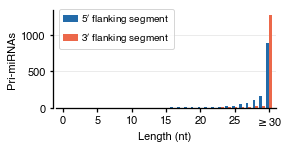

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4,1.8))
ax.bar(xs-.2,ys1,fc='#236ba9',width=.4,zorder=2,label='5$^\prime$ flanking segment')
ax.bar(xs+.2,ys2,fc='#ec684a',width=.4,zorder=2,label='3$^\prime$ flanking segment')

ax.set_xlabel('Length (nt)')
ax.set_ylabel('Pri-miRNAs')
ax.set_xticks(range(0,31,5))
ax.set_xticklabels(range(0,30,5)+['$\geq$30'])
ax.yaxis.grid(ls='-',lw=.5)
ax.legend(handlelength=1.5, handletextpad=.3, loc=(.03,.6))
#ax.axvline(13,color='#084594',ls='--',lw=1.3)
#ax.axvline(14,color='#4a1486',ls='--',lw=1.3)
ax.set_xlim(-1.5,31)
ax.spines['bottom'].set_bounds(-1,31)
#fig.savefig(resultpath + '210118_s1__flank_ours.pdf')

## S1F. Fragment composition

In [43]:
inds = ['Pri-miRNA','rstart','rend']
clvraw = pd.read_csv('supplementary/TableSub__cleavage_products_Microprocessor.csv',index_col=0)

/casa/bsc/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [44]:
START, MID, END = 1, 63, 125
DECAY = 4

In [45]:
pitbl = clvraw[['Pri-miRNA','rstart','rend']+PILOT]
pi5f = pitbl[(pitbl['rstart']<=START+DECAY)&(pitbl['rend']<MID)]
pi3f = pitbl[(pitbl['rstart']>MID)&(pitbl['rend']>=END-DECAY)]
pih = pitbl[(pitbl['rstart'].apply(lambda x: START+DECAY<x<MID))&\
            (pitbl['rend'].apply(lambda x: MID<x<END-DECAY))]

In [46]:
psum5f = pi5f[PILOT].sum().sum()
psumh = pih[PILOT].sum().sum()
psum3f = pi3f[PILOT].sum().sum()
psumel = pitbl[PILOT].sum().sum()-psum5f-psumh-psum3f
print 'pilot 5f:\t%i'%psum5f
print 'pilot hairpin:\t%i'%psumh
print 'pilot 3f:\t%i'%psum3f
print 'pilot else:\t%i'%psumel

pilot 5f:	3423624
pilot hairpin:	41500
pilot 3f:	771421
pilot else:	130743


In [47]:
pimirs = set(pitbl[(pitbl[PILOT]>0).all(axis=1)]['Pri-miRNA'])
print len(pimirs)

set1tbl = clvraw[['Pri-miRNA','rstart','rend']+SET1]
set1tbl = set1tbl.set_index('Pri-miRNA').loc[pimirs].reset_index()
s15f = set1tbl[(set1tbl['rstart']==START)&(set1tbl['rend']<MID)]
s13f = set1tbl[(set1tbl['rstart']>MID)&(set1tbl['rend']==END)]
s1h = set1tbl[(set1tbl['rstart']<MID)&(set1tbl['rend']>MID)]

8


In [48]:
s1sum5f = s15f[SET1].sum().sum()
s1sumh = s1h[SET1].sum().sum()
s1sum3f = s13f[SET1].sum().sum()
s1sumel = set1tbl[SET1].sum().sum()-s1sum5f-s1sumh-s1sum3f
print 'set1 5f:\t%i'%s1sum5f
print 'set1 hairpin:\t%i'%s1sumh
print 'set1 3f:\t%i'%s1sum3f
print 'set1 else:\t%i'%s1sumel

set1 5f:	170328
set1 hairpin:	70395
set1 3f:	156380
set1 else:	3961


In [49]:
ys1 = [ psum5f, psum3f, psumh, psumel ]
ys2 = [ s1sum5f, s1sum3f, s1sumh, s1sumel ]
ys1 = np.array(ys1)/sum(ys1)*100
ys2 = np.array(ys2)/sum(ys2)*100
c5, ch, c3, ce = '#236ba9', '#898989', '#ec684a', '#242424'
colors = [ c5, c3, ch, ce ]
labels = [ '5$^\prime$ flanking (F1)', '3$^\prime$ flanking (F3)', 'Hairpin (F2)', 'Others' ]

In [50]:
print ys1
print ys2

[78.39244859 17.66361641  0.95024647  2.99368853]
[42.46903237 38.99128319 17.55206152  0.98762292]


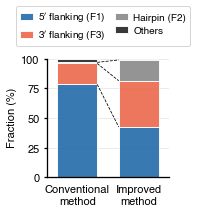

In [51]:
## color version
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
bottom = np.array([0.,0.])
for y1, y2, color, label in zip(ys1, ys2, colors, labels):
    ax.bar(range(2), [y1, y2], bottom=bottom, width=.65, linewidth=1, edgecolor='white',
           color=color, zorder=2, label=label, alpha=.9)
    bottom += np.array([y1,y2])
    if label not in labels[-1:]:
        l = lines.Line2D([.325,.675], bottom, linewidth=.8, color='black', linestyle='--')
        l.set_clip_on(False)
        ax.add_line(l)

ax.set_xlim(-.5, 1.5)
ax.set_ylim(0, 101)
ax.set_xticks([0,1])
ax.set_xticklabels(['Conventional\nmethod', 'Improved\nmethod'])
ax.set_yticks([0,25,50,75,100])
ax.set_yticklabels([0,25,50,75,100])
ax.set_ylabel('Fraction (%)')
ax.spines['left'].set_bounds(0,100)
ax.tick_params(bottom='off')
ax.legend(loc=(-.25,1.1), handlelength=1.3, labelspacing=.4, handletextpad=.5, 
          ncol=2, columnspacing=1)
ax.yaxis.grid(ls='-', lw=.5)
#fig.savefig(resultpath + '210118_s1f__fragment-composition.pdf')

## S1G-H. Reproducibility

In [52]:
inpraw = pd.read_csv('supplementary/TableSub__input_Microprocessor.csv',header=1,index_col=0)
inpsum = pd.DataFrame()
for inp in ['set1', 'set3', 'set5']:
    rep1 = '%s-1'%inp
    rep2 = '%s-2'%inp
    inpsum[inp] = inpraw[[rep1,rep2]].sum(axis=1)
inpsum['set2'] = inpraw['set2']
inpsum['set4'] = inpraw['set4'] 
inpsum = inpsum[LIBRARIES].astype(int)
inpsum.head(1)

,set1,set2,set3,set4,set5
Pri-miRNA,,,,,
hsa-let-7a-1,1373,474,0,2,0


In [53]:
synexcel = pd.ExcelFile('supplementary/synthesis_log.xlsx')
syn1mirs = synexcel.parse('1st')[0].tolist()
inpsub = inpsum.reindex(syn1mirs).dropna()
print len(inpsub)

1645


In [54]:
color, ecolor = '#969696', '#545454'
lw = .7
alpha = .6
s = 5
r1, r2 = 'set1', 'set2'
xs = np.log2(inpsub[r1]+1)
ys = np.log2(inpsub[r2]+1)
xmin, xmax = 0, 13
ymin, ymax = 0, 13

Text(0.5,1,u'log2 (Initial substrates + 1)')

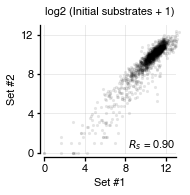

In [55]:
## reproducibility between replicates
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs, ys, s=10, color='k', lw=0, alpha=.1, zorder=2, rasterized=True)

ax.set_xticks(range(xmin, xmax, 4))
ax.set_yticks(range(ymin, ymax, 4))
ax.set_xlim(xmin-.4, xmax+.4)
ax.set_ylim(ymin-.4, ymax+.4)
ax.set_xlabel('Set #1', fontsize=11)
ax.set_ylabel('Set #2', fontsize=11)
ax.spines['bottom'].set_bounds(0, xmax)
ax.spines['left'].set_bounds(0, ymax)
r = spearmanr(xs, ys)[0]
ax.text(xmax, ymin+.5, '$R_s$ = %.2f'%r, fontsize=11, ha='right')

squ = plt.Rectangle((-.1,-.1), xmax+.1, ymax+.1, fc='w'); ax.add_patch(squ)
ax.grid(clip_path=squ, ls='-', lw=.5)
ax.set_title('log2 (Initial substrates + 1)', fontsize=11)
#fig.savefig(resultpath + '201123_s1g_reproducibility_input.pdf',dpi=300)

In [56]:
clvraw = clvraw.set_index(inds)
clvsum = pd.DataFrame()
for lib in LIBRARIES:
    clvsum[lib] = clvraw[['%s-1'%lib,'%s-2'%lib]].sum(axis=1)
clvsum = clvsum.reset_index()
clvtbl = clvsum.set_index('Pri-miRNA')
clvsum.head(1)

,Pri-miRNA,rstart,rend,set1,set2,set3,set4,set5
0,hsa-let-7a-1,1,8,4.0,4.0,0.0,0.0,0.0


In [57]:
clv5f = clvsum[(clvsum['rstart']==START)&(clvsum['rend']<MID)].set_index('Pri-miRNA')
clv3f = clvsum[(clvsum['rstart']>MID)&(clvsum['rend']==END)].set_index('Pri-miRNA')
clvhn = clvsum[(clvsum['rstart']<MID)&(clvsum['rend']>MID)]
clvn5 = clvhn[clvhn['rstart']==START]
clvn3 = clvhn[clvhn['rend']==END]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')
clvn5 = clvn5.set_index('Pri-miRNA'); clvn3 = clvn3.set_index('Pri-miRNA')

In [58]:
syn1clv = set(clv5f.index)&set(clv3f.index)&set(clvh.index)&set(syn1mirs)
print len(syn1clv)

1645


In [59]:
## reproducibility between replicates
r1,r2 = 'set1','set2'
#syn1clv = set(clv5f.index)&set(clv3f.index)&set(clvh.index)&set(syn1mirs)
xs5 = [ np.log2(clv5f.loc[mir,r1].sum()+1) for mir in syn1clv ]
ys5 = [ np.log2(clv5f.loc[mir,r2].sum()+1) for mir in syn1clv ]
xs3 = [ np.log2(clv3f.loc[mir,r1].sum()+1) for mir in syn1clv ]
ys3 = [ np.log2(clv3f.loc[mir,r2].sum()+1) for mir in syn1clv ]
xsh = [ np.log2(clvh.loc[mir,r1].sum()+1) for mir in syn1clv ]
ysh = [ np.log2(clvh.loc[mir,r2].sum()+1) for mir in syn1clv ]
r5 = spearmanr(xs5, ys5)[0]
r3 = spearmanr(xs3, ys3)[0]
rh = spearmanr(xsh, ysh)[0]
xmin, xmax = 2, 17
ymin, ymax = 0, 14

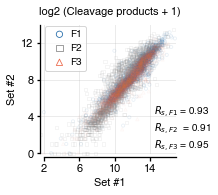

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
ax.scatter(xs5,ys5,s=10,facecolor='None',edgecolor='#236ba9',lw=.8,alpha=.1,marker='o',
           label='F1',zorder=2,rasterized=True)
ax.scatter(xsh,ysh,s=10,facecolor='None',edgecolor='#898989',lw=.8,alpha=.1,marker='s',
           label='F2',zorder=2,rasterized=True)
ax.scatter(xs3,ys3,s=10,facecolor='None',edgecolor='#ec684a',lw=.8,alpha=.05,marker='^',
           label='F3',zorder=2,rasterized=True)

ax.set_xticks(range(xmin, xmax, 4))
ax.set_yticks(range(ymin, ymax, 4))
ax.set_xlim(xmin-.4, xmax+.4)
ax.set_ylim(ymin-.4, ymax+.4)
ax.set_xlabel('Set #1', fontsize=11)
ax.set_ylabel('Set #2', fontsize=11)

ax.spines['bottom'].set_bounds(xmin, xmax)
ax.spines['left'].set_bounds(ymin, ymax)
ax.set_title('log2 (Cleavage products + 1)', fontsize=11)
ax.text(14.5,.5,'$R_{s,F1}$ = %.2f\n$R_{s,F2}$  = %.2f\n$R_{s,F3}$ = %.2f'%(r5,rh,r3))
leg = ax.legend(loc='upper left', handletextpad=.1, markerscale=2)
for lh in leg.legendHandles:
    lh.set_alpha(1)
squ = plt.Rectangle((-.1,-.1), xmax+.1, ymax+.1, fc='w'); ax.add_patch(squ)
ax.grid(clip_path=squ, ls='-', lw=.5)
#fig.savefig(resultpath + '201225_s1h_reproducibility_clv.pdf',dpi=300)

--- 
## 1D. Processing examples

In [133]:
EX = 'hsa-mir-4268' #'hsa-mir-125a'

In [164]:
bedcols = [ 'chr', 'start', 'end', 'rname', 'miRNA', 'strand' ]
bedfile = 'supplementary/fCLIP/293T/293T_191115_genome-annot_1881-pris_mp1_sp1.bed.gz'
ftmp = pd.read_table(gzip.open(bedfile,'rb'),usecols=[0,1,2,3,15,17],names=bedcols)
ftmp['start']=ftmp['start']+1
ftbl = pd.DataFrame()
ftbl['293T'] = ftmp.groupby(['miRNA','start','end','strand']).size()
ftbl = ftbl.reset_index()
ftbl.head(1)

,miRNA,start,end,strand,293T
0,hsa-let-7a-1,94175819,94175961,+,1


In [260]:
ps, pe = get_pre_annot(EX)[1:3]
fsub = ftbl[(ftbl['miRNA']==EX)&((ftbl['end']-ftbl['start'])>=40)]
fsub5 = fsub[fsub['start'].apply(lambda x: x in range(ps-100,ps-35))].sort_values('end')
fsubh1 = fsub[(fsub['end']==pe)].sort_values('start')
fsubh2 = fsub[(fsub['start']==ps)&(fsub['end']!=pe)].sort_values('end',ascending=False)
fsub3 = fsub[fsub['end'].apply(lambda x: x in range(pe+35,pe+100))].sort_values('start')
c = '#bcbddc'

2252


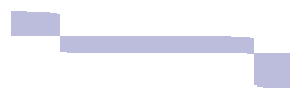

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(5,1.5))
bottom = 0
for mir,row in fsub5.iterrows():
    rs,re,cnt = row[['start','end','293T']]
    rs = rs-ps; re = re-ps
    sq = plt.Rectangle([rs,bottom],re-rs+1,cnt,fc=c); ax.add_patch(sq); bottom+=cnt
    
for mir,row in fsubh2[::-1].append(fsubh1).iterrows():
    rs,re,cnt = row[['start','end','293T']]
    rs = rs-ps; re = re-ps
    sq = plt.Rectangle([rs,bottom],re-rs,cnt,fc=c); ax.add_patch(sq); bottom+=cnt
    
for mir,row in fsub3.iterrows():
    rs,re,cnt = row[['start','end','293T']]
    rs = rs-ps; re = re-ps
    sq = plt.Rectangle([rs-1,bottom],re-rs+1,cnt,fc=c); ax.add_patch(sq); bottom+=cnt
    
ax.set_xlim(-15, 70)
ax.set_ylim(0,bottom)
ax.invert_yaxis()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
print bottom
fig.savefig(resultpath + '201124_f1d__mir125a_fCLIP.pdf')

In [134]:
ps, pe = preposition[EX]
isub = clvtbl.loc[EX]
isub5 = isub[(isub['rstart']==START)&(isub['rend']<MID)].sort_values('rend')
isubh1 = isub[(isub['rstart']<MID)&(isub['rend']==pe)].sort_values('rstart')
isubh2 = isub[(isub['rstart']==ps)&(isub['rend']!=pe)].sort_values('rend')
isub3 = isub[(isub['rend']==END)&(isub['rstart']>MID)].sort_values('rstart')
c = '#ababab'

3146


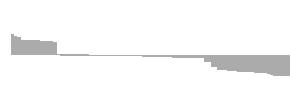

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5,1.5))
bottom = 0
for mir,row in isub5.iterrows():
    rs,re,cnt = row[['rstart','rend','set1']]
    rs = rs-ps; re = re-ps
    sq = plt.Rectangle([rs,bottom],re-rs+1,cnt,fc=c); ax.add_patch(sq); bottom+=cnt
    
for mir,row in isubh2.append(isubh1).iterrows():
    rs,re,cnt = row[['rstart','rend','set1']]
    rs = rs-ps; re = re-ps
    sq = plt.Rectangle([rs,bottom],re-rs,cnt,fc=c); ax.add_patch(sq); bottom+=cnt
    
for mir,row in isub3.iterrows():
    rs,re,cnt = row[['rstart','rend','set1']]
    rs = rs-ps; re = re-ps
    sq = plt.Rectangle([rs-1,bottom],re-rs+1,cnt,fc=c); ax.add_patch(sq); bottom+=cnt
    
ax.set_xlim(-15, 70)
ax.set_ylim(0,bottom)
ax.invert_yaxis()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
print bottom
#fig.savefig(resultpath + '201124_f1d__mir125a_IVP.pdf')

## 1E. Global cleavage site

In [36]:
RCUTOFF = 30
WINDOW = 3

In [37]:
def fill_unfound(tbl):
    found = set(tbl.index)
    unfound = [ mir for mir in allpris if mir not in found ]
    fill = pd.DataFrame(index=unfound, columns=tbl.columns).fillna(0)
    return tbl.append(fill)

In [38]:
def get_frac_5frag(mir):
    sub = clv5f.loc[[mir]].set_index('rend')
    return (sub/sub.sum())

In [39]:
def get_frac_3frag(mir):
    sub = clv3f.loc[[mir]].set_index('rstart')
    return (sub/sub.sum())

In [40]:
def get_frac_hairpin(mir):
    sub = clvh.loc[[mir]].set_index(['rstart','rend'])
    return (sub/sub.sum())

In [61]:
clv5f = fill_unfound(clv5f)
clv3f = fill_unfound(clv3f)
clvh = fill_unfound(clvh)
clvn5 = fill_unfound(clvn5)
clvn3 = fill_unfound(clvn3)

In [62]:
frac5f = { mir:get_frac_5frag(mir) for mir in allpris } 
frac3f = { mir:get_frac_3frag(mir) for mir in allpris } 
frachpn = { mir:get_frac_hairpin(mir) for mir in allpris }

In [63]:
tbl5 = pd.DataFrame(columns=range(-WINDOW,WINDOW+1))
for mir in sorted(allpris):
    lib = max(LIBRARIES, key=lambda x: clvtbl.loc[mir,x].sum())
    if clv5f.loc[mir,lib].sum()<=RCUTOFF:
        continue
    ps, pe = preposition[mir] 
    xs5 = np.arange(ps-WINDOW-1,ps+WINDOW)
    f5 = frac5f[mir].reindex(xs5).fillna(0)[lib]
    f5.index = range(-WINDOW,WINDOW+1)
    tbl5.loc[mir] = f5

In [64]:
len([m for m in drodep if m in tbl5.index])

310

In [65]:
tbl5.head()

,-3,-2,-1,0,1,2,3
hsa-let-7a-1,0.003005,0.007564,0.039322,0.938918,0.002435,0.000000,0.000000
hsa-let-7a-2,0.001620,0.003177,0.175804,0.760777,0.000187,0.000062,0.000125
hsa-let-7a-3,0.004471,0.034787,0.054526,0.741330,0.001854,0.004689,0.000000
hsa-let-7b,0.002518,0.003684,0.019220,0.894013,0.000246,0.000246,0.000061
hsa-let-7c,0.003240,0.002700,0.011206,0.201296,0.001080,0.002700,0.001755


In [66]:
cano5 = tbl5.reindex(drodep)
cano5 = cano5[(cano5>0).any(axis=1)]
nonc5 = tbl5.reindex(droind)
nocn5 = nonc5[(nonc5>0).any(axis=1)]
print len(cano5), len(nonc5)

308 257


In [67]:
xs = np.arange(-WINDOW,WINDOW+1)
ys1 = cano5.mean()*100
ys2 = nonc5.mean()*100

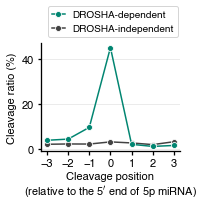

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))
ax.errorbar(xs,ys1,ms=6,marker='o',mec='w',color='#018571',zorder=3,mew=.8,
            label='DROSHA-dependent')
ax.errorbar(xs,ys2,ms=6,marker='o',mec='w',color='#424242',zorder=2,mew=.8,
            label='DROSHA-independent')
ax.set_xlabel('Cleavage position\n(relative to the 5$^\prime$ end of 5p miRNA)',fontsize=11)
ax.set_xticks(xs)
ax.set_ylabel('Cleavage ratio (%)',fontsize=11)
ax.yaxis.grid(ls='-',lw=.5)
ax.legend(handlelength=1.3,loc=(.05,1.05))
#fig.savefig(resultpath + '210118_f1e__specificity_v2.pdf')#,dpi=300)